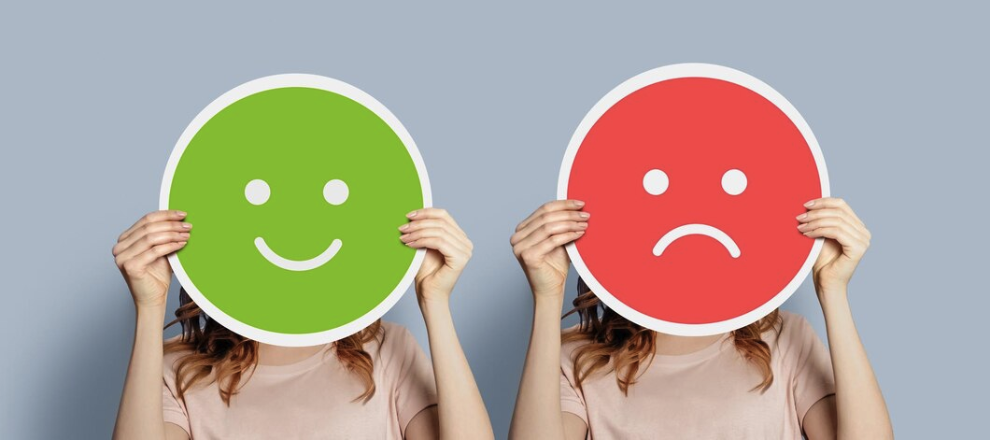



# **Facial Emotion Detection**

## **Problem Definition**

--------------
## **Context**
--------------

In the retail industry, understanding customer emotions plays a crucial role in improving customer experience, enhancing sales, and building brand loyalty. A facial emotion recognition model can be employed to achieve these goals.  Facial emotion recognition can be integrated into recommendation systems to provide personalized product recommendations based on customers' emotional states.  For instance, when a customer exhibits signs of happiness while exploring a specific product category, the system swiftly responds by curating a selection of related products or exclusive offers. This proactive approach not only augments the shopping experience but also fosters a deeper connection between the customer and the brand, resulting in heightened satisfaction and loyalty. Whether it's offering empathetic assistance during moments of uncertainty or celebrating moments of joy with personalized incentives, the model empowers retailers to forge meaningful connections that transcend transactional interactions.

----------------
## **Objective**
----------------

My objective is to predict the emotions depicted in images using Convolutional Neural Networks, with or without Transfer Learning. I will explore various CNN architectures and training strategies, evaluating their performance on the task of emotion recognition. Ultimately, I will select the model that demonstrates the highest accuracy and effectiveness in capturing emotional nuances from images.

----------------
## **Key Questions**
----------------

*  Within the data what are the key nuances that distinguish one emotion from another?
*  What metrics will be used to evaluate the performance?
*  What will be the training strategy, including batch size, learning rate, and optimization alorithm?
*  What ethical considerations need to be taken into account regarding the use of facial emotion recognition technology?
*  How will privacy concerns be addressed, particularly regarding the collection and use of facial data?
*  What are the implications of using facial data of minors?

----------------
## **Problem Formulation**
----------------

Currently the shopping experience does not adjust to the customers' emotional states. Are we able to detect cutomers' emotional state and cater their shopping experience to it?

-------------
## **Dataset**
-------------
The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>

----------------
## **Key Takeaways**
----------------

*  TODO

## **Mounting the Drive**

**NOTE:**  Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing the Libraries**

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
import os
import cv2

from enum import Enum
import random

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from keras import backend, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten

# Set the display format to 2 decimal places for floating-point numbers
pd.set_option('display.float_format', '{:.2f}'.format)

<a id="helper"></a>
### **Helper**

**Note:**
- I moved all the helper functions here so they would be easier to maintain.

In [5]:
TRAINING_DATA_DIR = '/content/Facial_emotion_images/train'
TEST_DATA_DIR = '/content/Facial_emotion_images/test'
VALIDATION_DATA_DIR = '/content/Facial_emotion_images/validation'

IMG_SIZE = 48

In [6]:
class Emotion(Enum):
  HAPPY = 'happy'
  SAD = 'sad'
  SURPRISE = 'surprise'
  NEUTRAL = 'neutral'

# extract class labels from Emotion Enum
CLASSES = [member.value for member in Emotion.__members__.values()]
CLASS_COUNT = len(Emotion.__members__)

In [7]:
def get_data(dir_path):
  """
  Function to read images from a directory and create a DataFrame containing
  the resized images and their corresponding categories.

  Args:
    dir_path (str): Path to directory containing data

  Returns:
    data (DataFrame): Dataframe containing data found in dir_path

  Note:
    Assumes the existence of two global variables:
    - Emotion: An enum of category names.
    - IMG_SIZE: The desired size for the resized images.
  """
  data = [] # initialize an empty list to store data

  # loop through all the categories
  for emotion in Emotion:
    category_path = os.path.join(dir_path, emotion.value)  # Get the path for the current category

    # loop through all the images in the current category
    for img_name in os.listdir(category_path):
      # read the image using OpenCV
      img_array = cv2.imread(os.path.join(category_path, img_name))

      # add image to data list
      data.append([img_array, emotion.value])

  # convert the training data list to DataFrame with columns "Image" and "Category"
  return pd.DataFrame(data, columns=['Image','Category'])

In [8]:
def show_category_images(emotion, data, sampleCount = 12):
  """
  Display a sample of images from a specific category.

  Args:
    emotion (enum) : Category used to filter the images
    data (DataFrame) : Dataframe used to as the source of images
    sampleCount (int) : Number of images to display.  Default is 12
  """

  # get list of images in the directory for specified category
  category_imgs = data[data['Category'] == emotion.value]['Image']

  print(f"Number of images: {category_imgs.count()}")

  # select a random sample of image file names
  samples = np.random.choice(category_imgs, sampleCount, replace=False)

  # create a new figure for plotting
  fig = plt.figure(figsize=(10, 10))

  # loop over the sample images
  for i, img in enumerate(samples):

    # add subplot
    ax = fig.add_subplot(6,4,i+1)

    # Load the image from the array
    loaded_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Resize the images to keep them consistent
    loaded_img = cv2.resize(loaded_img, (IMG_SIZE, IMG_SIZE))

    # display image
    plt.imshow(loaded_img)

    # turn off axis labels
    plt.axis('off')

    # add title
    plt.title(emotion.value)

  # show the figure
  plt.show()

In [9]:
def add_gaussian_noise(image):
  '''
  Add gaussian noise to the image.

  Args:
    image (numpy array): The image to add noise to.
  Returns:
    numpy array: The image with added noise.
  '''

  # define the mean and variance of Gaussian noise
  mean = 0
  var = np.random.randint(1,26) # randomly select variace between 1 and 25

  # generate gaussian noise
  noise = np.random.normal(mean, var**0.5, image.shape)

  # add the noise to the original image
  image = image + noise

  # clip the pixel values to be between 0 and 255 and convert pixel values to int
  return np.clip(image, 0, 255)

In [67]:
def custom_augmentation(image, add_noise=True, preprocessing_func=None):
  '''
  Perform custom augmentation on the image.

  Args:
    image (numpy array): The image to perform augmentation on.
    add_noise (bool): Whether to add Gaussian noise to the image. Default is True.
    preprocessing_func (function): A function to apply preprocessing to the image.
  Returns:
    numpy array: The augmented image.
  '''

  if add_noise:
    image = add_gaussian_noise(image)

  if preprocessing_func != None:
    image = preprocessing_func(image)

  return np.array(image)

In [125]:
def load_data(folder_path, preprocessing_func=None, augment=False, add_noise=False, shuffle=False, color_mode = "grayscale"):
    """
    Load image data from a directory using an ImageDataGenerator.

    Args:
        folder_path (str): Path to the directory containing image data.
        preprocessing_func (function): Function to apply custom augmentation to images.
        augment (bool): Whether to perform data augmentation. Default is False.
        add_noise (bool): Whether to add Gaussian noise to the images. Default is False.
        shuffle (bool): Whether to shuffle the data. Default is False.
        color_mode (str): Color mode for the images. Default is "grayscale".

    Returns:
        DirectoryIterator: A DirectoryIterator yielding batches of augmented images and labels.

    Note:
        Assumes the existence of the following global variables:
        - IMG_SIZE: The target size for the images.
        - CLASSES: A list of emotion categories.

    """

    rescale_value = 1.0/ 255.0 # Rescale pixel values to [0, 1]
    datagen = None

    # Create an ImageDataGenerator object for image augmentation
    if augment:
      datagen = ImageDataGenerator(rescale=rescale_value,
                                  horizontal_flip=True,
                                  vertical_flip=False, # upside down smile is a frown
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  brightness_range=[0.3, 1],
                                  data_format='channels_last')
    else:
      datagen = ImageDataGenerator(rescale=rescale_value, data_format='channels_last')

    if add_noise == True or preprocessing_func != None:
      datagen.preprocessing_function = lambda x: custom_augmentation(x,
                                                                     add_noise=add_noise,
                                                                     preprocessing_func=preprocessing_func)

    # flow images in batches of 32 using datagen generator
    return datagen.flow_from_directory(
        folder_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=32,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=shuffle)

In [12]:
def get_test_data_split(data):
  """
  Gets the images and labels from all the batches in the test data.

    Args:
        data (DataFrame): DataFrame containing the image data.

    Returns:
        tuple: A tuple containing the test images and labels.

  """
  # get the total number of batches
  total_batches = len(data)

  # initialize empty lists to store all the test images and labels
  test_images = []
  test_labels = []

  # interate over all batches for test data
  for _ in range(total_batches):
    testX, testY = next(data)
    test_images.append(testX)
    test_labels.append(testY)

  # concatenate the lists of images and labels
  testX = np.concatenate(test_images)
  testY = np.concatenate(test_labels)

  return testX, testY

In [13]:
def reset():
  SEED = 42

  backend.clear_session() # Remove the model for session

  # Setting numpy random seed
  np.random.seed(SEED)

  # Setting python random seed
  random.seed(SEED)

  # Setting TensorFlow random seed
  tf.random.set_seed(SEED)

In [14]:
def plot_history(history, model_name):
  '''
  This function plots the accuracies of the model.

    Args:
      history (history object): history object of the model
      model_name(str): name of the model
  '''

  print(f'Maximum Training Accuracy Score: {max(history.history["accuracy"])*100:.2f}%')
  print(f'Maximum Validation Accuracy Score: {max(history.history["val_accuracy"])*100:.2f}%')

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(f'{model_name} Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc = 'upper left')
  plt.show()

In [15]:
def plot_confusion_matrix(model):
    """
    This function prints and plots the confusion matrix.

    Args:
        model (Sequential): The trained model.
        test_labels (numpy array): The true labels of the test data.

    Note:
        Assumes the existence of the following global variables:
        - CLASSES: A list of emotion categories.
    """

    # predicting labels for the test images
    y_pred = model.predict(testX)

    # getting the highest rated predicted labels
    preds = np.argmax(y_pred, axis = 1)

    # getting the highest true labels
    y_true = np.argmax(testY, axis = 1)

    # showing the Precision, Recall, F1-score etc... for each category
    print(classification_report(y_true, preds, target_names=CLASSES))

    # plotting the confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_true, preds, display_labels=CLASSES);

### **Let us load and unzip the data**

**Note:**
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [17]:
ZIP_PATH = '/content/drive/MyDrive/MIT/Capstone Project/Facial_emotion_images.zip'

# unzipping data file to google colab
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall()

In [18]:
training_data = get_data(TRAINING_DATA_DIR)
print(f'Training Data has {training_data.shape[0]} rows and {training_data.shape[1]} columns')

img_size = training_data.iloc[0]['Image'].shape[:2]
img_channel = training_data.iloc[0]['Image'].shape[-1]

print(f'Image size is,{img_size}. {img_channel} channels = RGB inidcating the images are in color.')

Training Data has 15109 rows and 2 columns
Image size is,(48, 48). 3 channels = RGB inidcating the images are in color.


In [19]:
testing_data = get_data(TEST_DATA_DIR)
print(f'Testing Data has {testing_data.shape[0]} rows and {testing_data.shape[1]} columns')

img_size = testing_data.iloc[0]['Image'].shape[:2]
img_channel = training_data.iloc[0]['Image'].shape[-1]

print(f'Image size is,{img_size}. {img_channel} channels = RGB inidcating the images are in color.')

Testing Data has 128 rows and 2 columns
Image size is,(48, 48). 3 channels = RGB inidcating the images are in color.


In [20]:
validation_data = get_data(VALIDATION_DATA_DIR)
print(f'Validation Data has {validation_data.shape[0]} rows and {validation_data.shape[1]} columns')

img_size = validation_data.iloc[0]['Image'].shape[:2]
img_channel = validation_data.iloc[0]['Image'].shape[-1]

print(f'Image size is,{img_size}. {img_channel} channels = RGB inidcating the images are in color.')

Validation Data has 4977 rows and 2 columns
Image size is,(48, 48). 3 channels = RGB inidcating the images are in color.


## **Visualizing our Classes**

Let's look at our classes.

**Write down your observation for each class. What do you think can be a unique feature of each emotion, that separates it from the remaining classes?**

### **Happy**

**Observations and Insights:**


*   There are 3976 happy images in the training data.
*   The images seemed to be in greyscale not in color like the 3 color channels suggested.
*   Happy images generally show a face with a smile.
*   Happy images generally show a face and teeth but not always.
*   It would be interesting if the models pick up on the happiness in the eyes but that would be hard to articulate.

Number of images: 3976


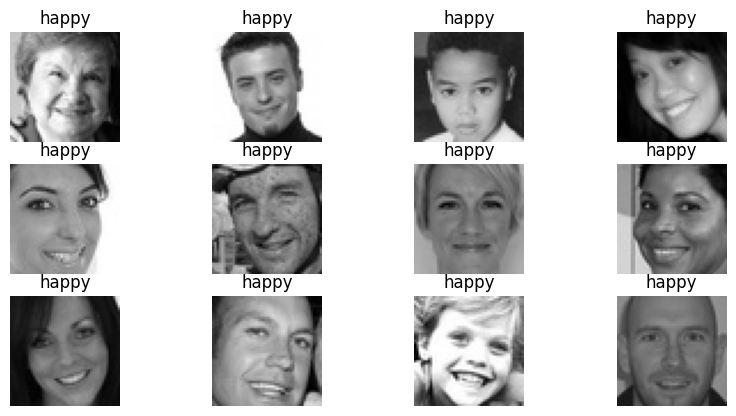

In [ ]:
show_category_images(Emotion.HAPPY, training_data)

### **Sad**

**Observations and Insights:**


*   There are 3982 sad images in the training data.
*   The images seemed to be in greyscale not in color like the 3 color channels suggested.
*   Sad images generally show a face with turned down lips, and or crying.
*   It would be interesting if the models pick up on the sadness in the eyes but that would be hard to articulate.

Number of images: 3982


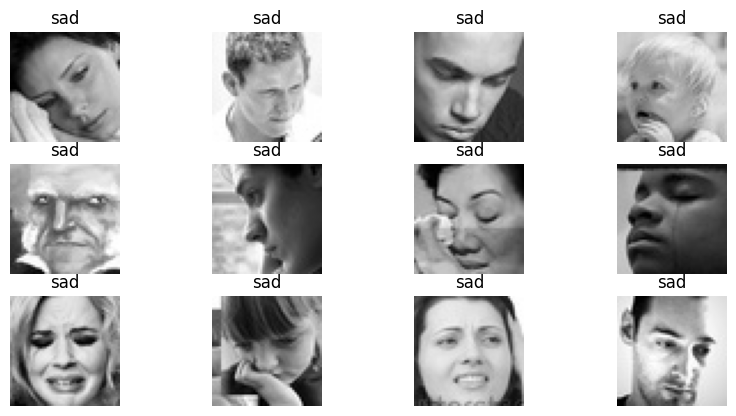

In [ ]:
show_category_images(Emotion.SAD, training_data)

### **Neutral**

**Observations and Insights:**


*   There are 3978 neutral images in the training data.
*   The images seemed to be in greyscale not in color like the 3 color channels suggested.
*   Some of the neutral images look like other emotions like sad and angry.  It will interesting to see the the models have an issue distinguishing between neutral and other emotions like sad.
*   Neutral images look like emotionless faces if not sad.

Number of images: 3978


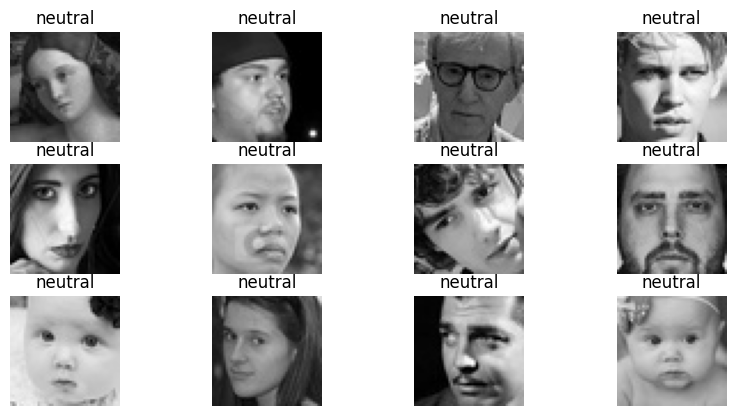

In [ ]:
show_category_images(Emotion.NEUTRAL, training_data)

### **Surprised**

**Observations and Insights:**


*   There are 3173 surprised images in the training data.
*   The images seemed to be in greyscale not in color like the 3 color channels suggested.
*   A lot of the surprised images have open mouths, but not all of them.  It will be interesting to see if the model zeros in on that.
*   It would be interesting if the models pick up on the surprise in the eyes but that would be hard to articulate.

Number of images: 3173


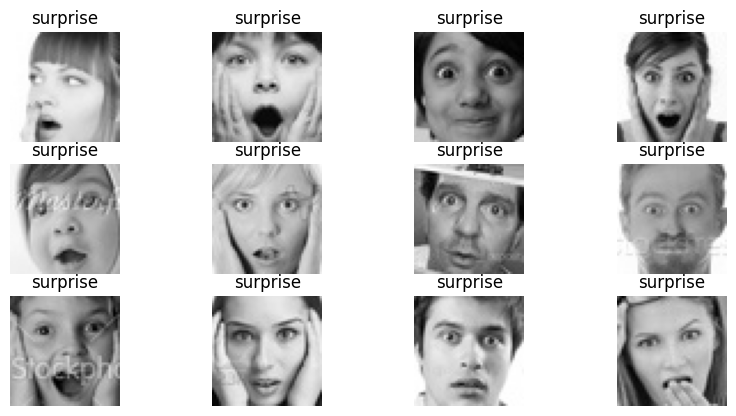

In [ ]:
show_category_images(Emotion.SURPRISE, training_data)

## **Checking Distribution of Classes**

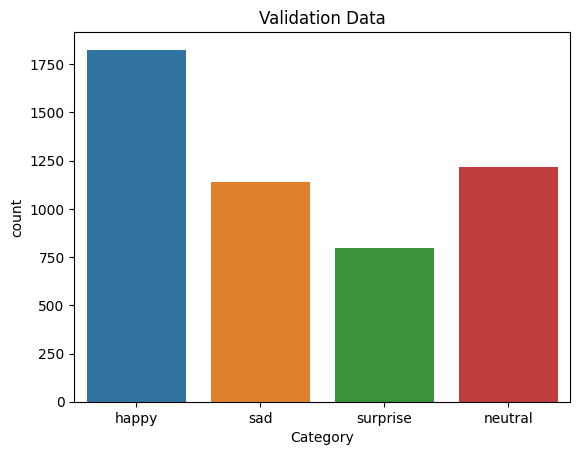

In [ ]:
sns.countplot(x='Category', data=validation_data, hue="Category", legend=False);
plt.title("Validation Data")
plt.show()

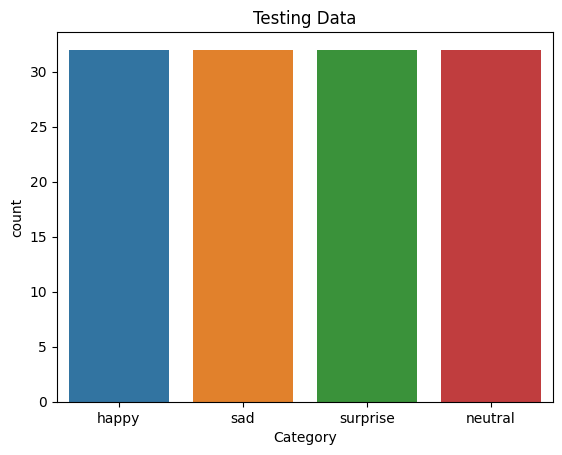

In [ ]:
sns.countplot(x='Category', data=testing_data, hue="Category", legend=False);
plt.title("Testing Data")
plt.show()

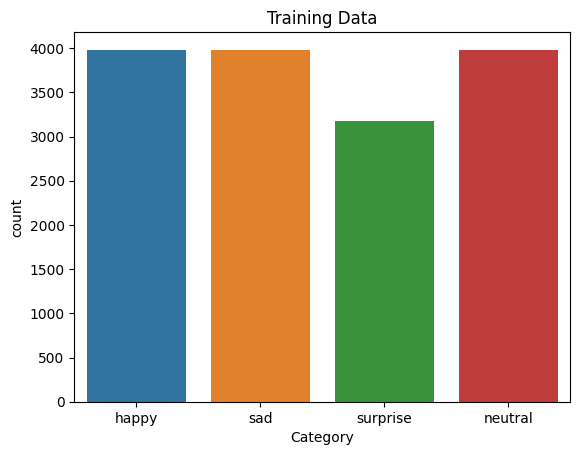

In [ ]:
sns.countplot(x='Category', data=training_data, hue="Category", legend=False);
plt.title("Training Data")
plt.show()

**Observations and Insights:**

The data is not highly imbalanced, but the number of images for the **surprise** emotion is less than the other emotions.  Because of this slight imbalance I will use evaluation methods like...


  *   **Confusion Matrix** which will provides a detailed breakdown of correct and incorrect classifications.
  *   **Accuracy** which will evaluate the test data to see how many the model got correct.
  *   **F1-Score** which will give me an indication of how well the model correctly classifies the emotions while minizing false negatives and false postives i.e. incorrectly classifying the emotions.

**Think About It:**
* Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
  
  - The data is slightly imabalanced wish the surpised category a little less the the other emotions.  This may cause the model to select the majority classes more than the minority one.  I will keep an eye out for this when testing the models.
* Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?

  - We can check the image demensions to make sure they are consistent.

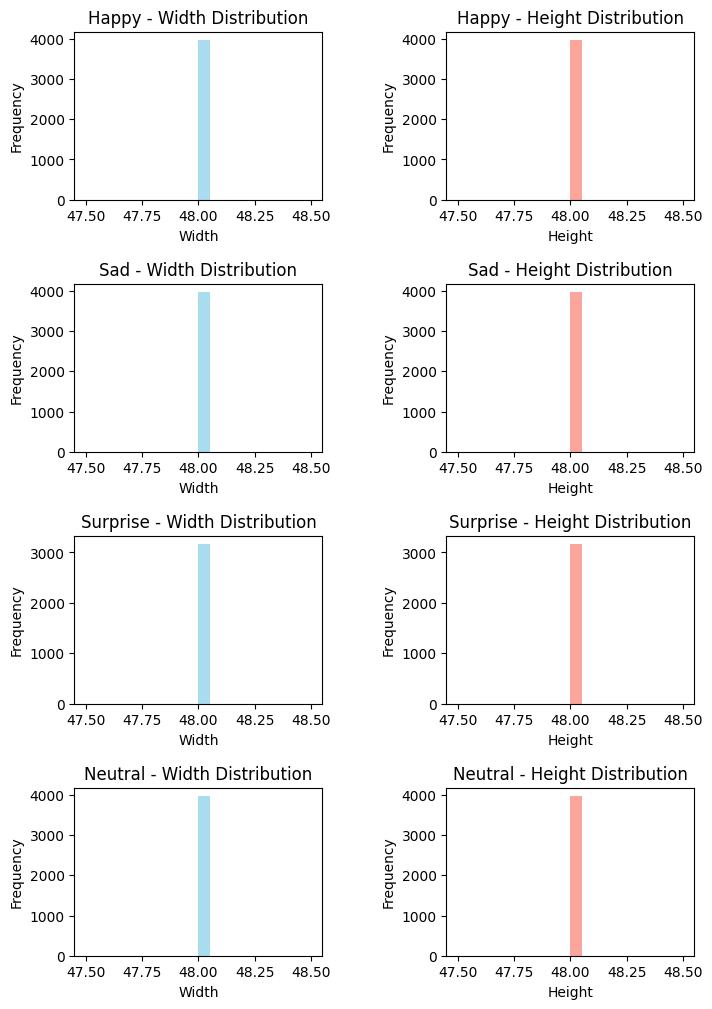

In [ ]:
# Calculate width and height for each image
training_data['width'] = training_data['Image'].apply(lambda x: x.shape[1])  # Width of the image
training_data['height'] = training_data['Image'].apply(lambda x: x.shape[0])  # Height of the image

# Plot histogram of width and height for each category
categories = training_data['Category'].unique()
num_categories = len(categories)

fig, axes = plt.subplots(nrows=num_categories, ncols=2, figsize=(8, 3*num_categories))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, category in enumerate(categories):
    category_data = training_data[training_data['Category'] == category]
    axes[i, 0].hist(category_data['width'], bins=20, color='skyblue', alpha=0.7)
    axes[i, 0].set_title(f'{category.capitalize()} - Width Distribution')
    axes[i, 0].set_xlabel('Width')
    axes[i, 0].set_ylabel('Frequency')

    axes[i, 1].hist(category_data['height'], bins=20, color='salmon', alpha=0.7)
    axes[i, 1].set_title(f'{category.capitalize()} - Height Distribution')
    axes[i, 1].set_xlabel('Height')
    axes[i, 1].set_ylabel('Frequency')

plt.show()

# Clean up data
training_data.drop(columns=['width', 'height'], inplace=True)

**Observations and Insights:**


*   All the training images are consistently 48x48

## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**

*I created helper functions located in the [helper](#helper) section that assist in creating the data loaders.  I will be using them throughout the model building.*



In [35]:
train_grayscale_set = load_data(TRAINING_DATA_DIR, add_noise=True, augment=True, shuffle=True);
test_grayscale_set = load_data(TEST_DATA_DIR);
validation_grayscale_set = load_data(VALIDATION_DATA_DIR);

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_grayscale_set)

Found 15109 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


## **Model Building**

**Think About It:**
* Are Convolutional Neural Networks the right approach? Should we have gone with Artificial Neural Networks instead?

  - Yes, the Convulational Neural Networks is the correct approach because of the convolutional and pooling layers.  These layers allows the model to capture heirarcheis of features (from simple edges to more complex patterns) within the images more effectively.
* What are the advantages of CNNs over ANNs and are they applicable here?

  - CNNs are designed to understand images better
  - CNNs lean faster than ANNs
  - CNNs are less prone to overfitting



### **Creating the Base Neural Network**

#### Greyscale Color Mode

In [ ]:
reset()

In [ ]:
# Initializing the Convolutional Neural Network
base_cnn_grayscale_model = Sequential([
    # Convolutional layer with 256 filters, each of size 5x5, using ReLU activation
    Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)),
    # Max pooling layer with pool size 2x2 and stride 2x2
    MaxPooling2D(strides=(2,2)),
    # Dropout layer to prevent overfitting by randomly dropping 25% of the units
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.25),

    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.25),

    # Flatten layer to convert the 2D feature maps into a 1D feature vector
    Flatten(),

    Dense(64, activation='relu'),  # A fully connected with 64 nodes as the first layer
    Dense(32, activation='relu'),  # A fully connected with 42 nodes as the second layer which is reduced to prevent overfitting
    # Output layer with CLASS_COUNT (4) neurons and softmax activation for multi-class classification
    Dense(CLASS_COUNT, activation='softmax')
])

# Print the model summary
base_cnn_grayscale_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       6656      
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        147520    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0

##### **Compiling and Training the Model**

In [ ]:
# compile the adam optimizer
optimizer = Adam(learning_rate=0.001)

# compile the model
base_cnn_grayscale_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# stop the training when a validation accuracy has stopped improving
es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=5, restore_best_weights=True)

best_base_cnn_grayscale_model = "best_base_cnn_grayscale_model.h5"

# save the best model during training
mc = ModelCheckpoint(best_base_cnn_grayscale_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# fit the model to the train dataset
base_cnn_grayscale_model_history = base_cnn_grayscale_model.fit(train_grayscale_set,
                                            validation_data = validation_grayscale_set,
                                            verbose = 1,
                                            epochs = 100,
                                            callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.3742 - accuracy: 0.2846
Epoch 1: val_accuracy improved from -inf to 0.38316, saving model to best_base_cnn_grayscale_model.h5
473/473 [==============================] - 22s 43ms/step - loss: 1.3742 - accuracy: 0.2846 - val_loss: 1.3446 - val_accuracy: 0.3832
Epoch 2/100
  3/473 [..............................] - ETA: 18s - loss: 1.3614 - accuracy: 0.3542

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


472/473 [============================>.] - ETA: 0s - loss: 1.3271 - accuracy: 0.3509
Epoch 2: val_accuracy did not improve from 0.38316
473/473 [==============================] - 20s 42ms/step - loss: 1.3270 - accuracy: 0.3509 - val_loss: 1.2806 - val_accuracy: 0.3376
Epoch 3/100
472/473 [============================>.] - ETA: 0s - loss: 1.2775 - accuracy: 0.3820
Epoch 3: val_accuracy did not improve from 0.38316
473/473 [==============================] - 20s 41ms/step - loss: 1.2772 - accuracy: 0.3824 - val_loss: 1.2416 - val_accuracy: 0.3810
Epoch 4/100
472/473 [============================>.] - ETA: 0s - loss: 1.2435 - accuracy: 0.3972
Epoch 4: val_accuracy improved from 0.38316 to 0.44686, saving model to best_base_cnn_grayscale_model.h5
473/473 [==============================] - 19s 41ms/step - loss: 1.2433 - accuracy: 0.3972 - val_loss: 1.2003 - val_accuracy: 0.4469
Epoch 5/100
472/473 [============================>.] - ETA: 0s - loss: 1.2163 - accuracy: 0.4281
Epoch 5: val_accur

##### **Model Evaluation**

In [ ]:
# load the best model
base_cnn_grayscale_model.load_weights(best_base_cnn_grayscale_model)

Maximum Training Accuracy Score: 63.12%
Maximum Validation Accuracy Score: 69.64%


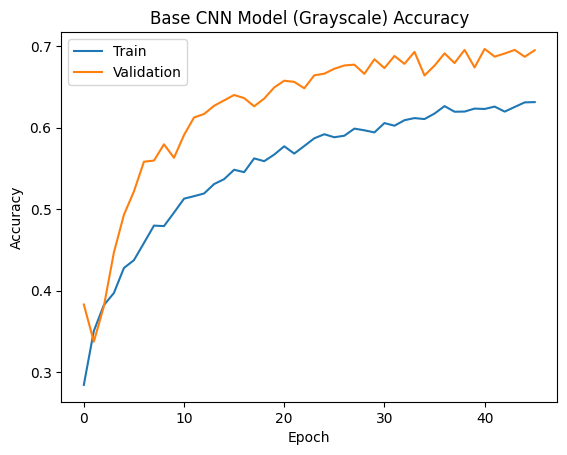

In [ ]:
plot_history(base_cnn_grayscale_model_history, "Base CNN Model (Grayscale)")

##### **Evaluating the Model on the Test Set**

In [ ]:
# get the metric value
accuracy = base_cnn_grayscale_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.7414 - accuracy: 0.6797 - 39ms/epoch - 10ms/step
Test Accuracy: 67.97%


**Observations and Insights:**

- The grayscale CNN model has given an accuracy of about 68% on the the test data (depending on the run).
-  Because of the added augmentation to the training data and the early stopping the model is not overfitting.  Which is good.
- The steady rise of the validation accuracy over the training accuracy shows that the performance is good.
- Best epoch was 41 with 70% validation accuracy

##### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

       happy       0.76      0.81      0.79        32
         sad       0.54      0.62      0.58        32
    surprise       0.52      0.47      0.49        32
     neutral       0.93      0.81      0.87        32

    accuracy                           0.68       128
   macro avg       0.69      0.68      0.68       128
weighted avg       0.69      0.68      0.68       128



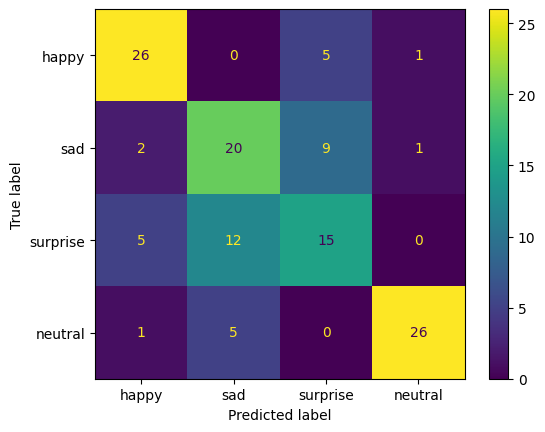

In [ ]:
plot_confusion_matrix(base_cnn_grayscale_model)

**Observations and Insights:**

*   The model seems to be the surest about neutral faces with highest f1-score.  This was unexpected since this was one of the most vague emotions.
*  The model was the least sure about the surprise emotion.  It often confused it with the sad emotion.

#### RGB Color Mode

*Fitting the RGB datasets to see if I get better accuracies.*

In [21]:
reset()

In [22]:
train_rgb_set = load_data(TRAINING_DATA_DIR, add_noise=True, augment=True, shuffle=True, color_mode = 'rgb');
test_rgb_set = load_data(TEST_DATA_DIR, color_mode = 'rgb');
validation_rgb_set = load_data(VALIDATION_DATA_DIR, color_mode = 'rgb');

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_rgb_set)

Found 15109 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


In [23]:
# Initializing the Convolutional Neural Network
base_cnn_rgb_model = Sequential([
    # Convolutional layer with 256 filters, each of size 5x5, using ReLU activation
    Conv2D(256, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    # Max pooling layer with pool size 2x2 and stride 2x2
    MaxPooling2D(strides=(2,2)),
    # Dropout layer to prevent overfitting by randomly dropping 25% of the units
    Dropout(0.25),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.25),

    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(strides=(2,2)),
    Dropout(0.25),

    # Flatten layer to convert the 2D feature maps into a 1D feature vector
    Flatten(),

    Dense(64, activation='relu'),  # A fully connected with 64 nodes as the first layer
    Dense(32, activation='relu'),  # A fully connected with 42 nodes as the second layer which is reduced to prevent overfitting
    # Output layer with CLASS_COUNT (4) neurons and softmax activation for multi-class classification
    Dense(CLASS_COUNT, activation='softmax')
])

# Print the model summary
base_cnn_rgb_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       19456     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        147520    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0

##### **Compiling and Training the Model**

In [24]:
# compile the adam optimizer
optimizer = Adam(learning_rate=0.001)

base_cnn_rgb_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

best_base_cnn_rgb_model = "best_base_cnn_rgb_model.h5"

# stop the training when a validation accuracy has stopped improving
es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=5, restore_best_weights=True)

# save the best model during training
mc = ModelCheckpoint(best_base_cnn_rgb_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model to the train dataset
base_cnn_rgb_model_history = base_cnn_rgb_model.fit(train_rgb_set,
                                            validation_data = validation_rgb_set,
                                            verbose = 1,
                                            epochs = 100,
                                            callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.3805 - accuracy: 0.2759
Epoch 1: val_accuracy improved from -inf to 0.38196, saving model to best_base_cnn_rgb_model.h5
473/473 [==============================] - 33s 58ms/step - loss: 1.3805 - accuracy: 0.2759 - val_loss: 1.3711 - val_accuracy: 0.3820
Epoch 2/100
  2/473 [..............................] - ETA: 25s - loss: 1.3792 - accuracy: 0.2812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - ETA: 0s - loss: 1.3651 - accuracy: 0.3011
Epoch 2: val_accuracy did not improve from 0.38196
473/473 [==============================] - 27s 57ms/step - loss: 1.3651 - accuracy: 0.3011 - val_loss: 1.3651 - val_accuracy: 0.3161
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.3638 - accuracy: 0.3044
Epoch 3: val_accuracy did not improve from 0.38196
473/473 [==============================] - 27s 57ms/step - loss: 1.3638 - accuracy: 0.3044 - val_loss: 1.3574 - val_accuracy: 0.3257
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.3309 - accuracy: 0.3449
Epoch 4: val_accuracy did not improve from 0.38196
473/473 [==============================] - 27s 58ms/step - loss: 1.3309 - accuracy: 0.3449 - val_loss: 1.3182 - val_accuracy: 0.3643
Epoch 5/100
473/473 [==============================] - ETA: 0s - loss: 1.2979 - accuracy: 0.3689
Epoch 5: val_accuracy did not improve from 0.38196
473/473 [============

##### **Model Evaluation**

In [25]:
# load the best model
base_cnn_rgb_model.load_weights(best_base_cnn_rgb_model)

Maximum Training Accuracy Score: 62.96%
Maximum Validation Accuracy Score: 69.82%


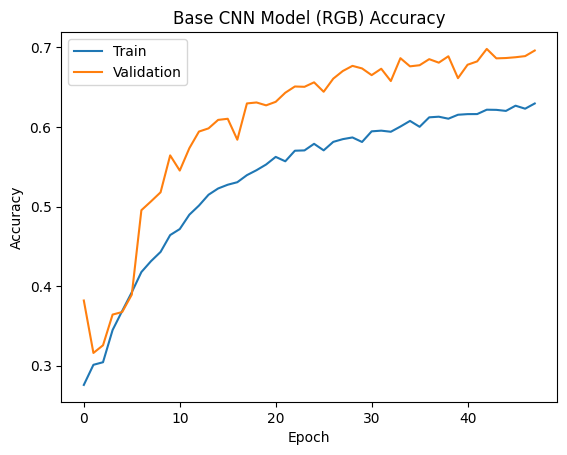

In [26]:
plot_history(base_cnn_rgb_model_history, "Base CNN Model (RGB)")

##### **Evaluating the Model on the Test Set**

In [27]:
# get the accuracy value
accuracy = base_cnn_rgb_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.6850 - accuracy: 0.7266 - 40ms/epoch - 10ms/step
Test Accuracy: 72.66%


**Observations and Insights:**

- The RGB CNN model has given an accuracy of ~73% on the the test data (depending on the run).
- Setting the color mode to RGB **did** improved the accuracy slightly.
- Early stopping stopped before the model began to overfit.
- Best epoch was 43 with 70% validation accuracy which is the same as the CNN grayscale models best validation accuracy of 70%.

##### **Classification Report and Confusion Matrix for Test Predictions**


4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       happy       0.75      0.84      0.79        32
         sad       0.61      0.69      0.65        32
    surprise       0.61      0.53      0.57        32
     neutral       0.96      0.84      0.90        32

    accuracy                           0.73       128
   macro avg       0.73      0.73      0.73       128
weighted avg       0.73      0.73      0.73       128



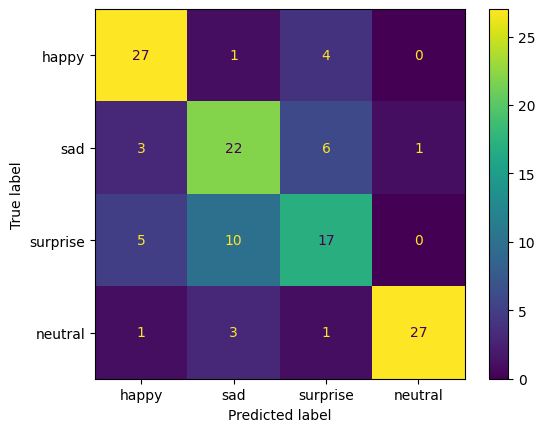

In [28]:
plot_confusion_matrix(base_cnn_rgb_model)

**Observations and Insights:**

*   Like the grayscale model the CNN RGB model seems to be the surest about neutral emotions with highest f1-score.
*  The model seems to confuse surprise emotions with happy emotions which if you look at the eyes in those images it's kind of understanble.
*  The model also often confused sad emotions with surprise emotions.



### **Creating the second Convolutional Neural Network**

- Try out a slightly larger architecture

In [29]:
reset()

In [36]:
# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_grayscale_set)

In [37]:
# Initializing the Convolutional Neural Network
cnn_model_2 = Sequential([
    # Convolutional layer with 256 filters, each of size 3x3, using ReLU activation
    Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,1)),
    LeakyReLU(alpha=0.1), # adding non-linearity and mitigage dying ReLU problem
    Conv2D(64, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(), # Used to normalize the activations and stabilize the training process which can accerlerate the training process
    Conv2D(64, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.25),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(2,2),
    Dropout(0.25),
    BatchNormalization(),
    Flatten(), # Flatten layer to convert the 2D feature maps into a 1D feature vector
    Dense(32, activation='relu'),  # a fully connected with 32 nodes as the dense layer
    LeakyReLU(alpha=0.1),
    Dropout(0.25),
    Dense(16, activation='relu'),  # a fully connected with 16 nodes as the dense layer
    # Output layer with CLASS_COUNT (4) neurons and softmax activation for multi-class classification
    Dense(CLASS_COUNT, activation='softmax')
])

cnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 256)       2560      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 48, 48, 256)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        147520    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 24, 24, 64)        0         
                                                      

#### **Compiling and Training the Model**

In [39]:
# Create an Adam optimizer with a learning rate of 0.001
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile model
cnn_model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

best_cnn_model = "best_cnn_model.h5"

# stop the training when a validation accuracy has stopped improving
es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=5, restore_best_weights=True)

# save the best model during training
mc = ModelCheckpoint(best_cnn_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model to the train dataset
cnn_model_history = cnn_model_2.fit(train_grayscale_set,
                                  validation_data = validation_grayscale_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.4100 - accuracy: 0.2682
Epoch 1: val_accuracy improved from -inf to 0.22624, saving model to best_cnn_model.h5
473/473 [==============================] - 21s 39ms/step - loss: 1.4100 - accuracy: 0.2682 - val_loss: 1.4203 - val_accuracy: 0.2262
Epoch 2/100
472/473 [============================>.] - ETA: 0s - loss: 1.3750 - accuracy: 0.2794
Epoch 2: val_accuracy improved from 0.22624 to 0.23729, saving model to best_cnn_model.h5
473/473 [==============================] - 18s 38ms/step - loss: 1.3750 - accuracy: 0.2796 - val_loss: 1.4162 - val_accuracy: 0.2373
Epoch 3/100
472/473 [============================>.] - ETA: 0s - loss: 1.3719 - accuracy: 0.2842
Epoch 3: val_accuracy improved from 0.23729 to 0.29094, saving model to best_cnn_model.h5
473/473 [==============================] - 17s 37ms/step - loss: 1.3719 - accuracy: 0.2840 - val_loss: 1.3631 - val_accuracy: 0.2909
Epoch 4/100
472/473 [======================

#### **Model Evaluation**

In [40]:
# load the best model
cnn_model_2.load_weights(best_cnn_model)

Maximum Training Accuracy Score: 65.96%
Maximum Validation Accuracy Score: 72.41%


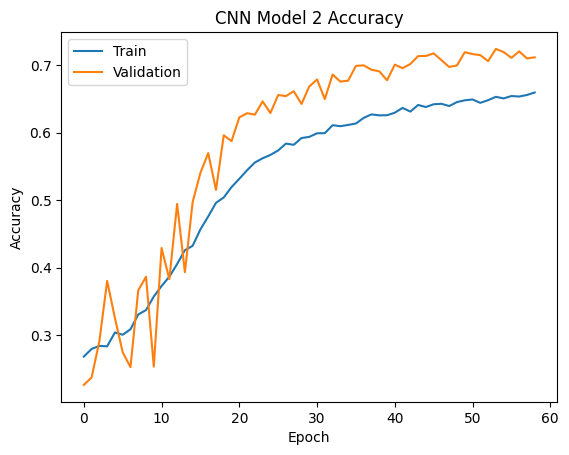

In [41]:
plot_history(cnn_model_history, "CNN Model 2")

#### **Evaluating the Model on the Test Set**

In [42]:
# get the accuracy value
accuracy = cnn_model_2.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.6938 - accuracy: 0.7109 - 51ms/epoch - 13ms/step
Test Accuracy: 71.09%


**Observations and Insights:**

- The CNN model has an accuracy of 71% on the test data.  Which is on par with the previous models.
-  I used the grayscale test set because it was performing just about as well as the RGB model with 1 color channel.  Also this model seems to work better with the grayscale data.
- The validation data accuracy is well above the training data accuracy which is a good sign that the model will generalize well on unseen data.
- The best epoch was #54 which had a validation accuracy of 72%.
- So far this is the best performing models are the RGB and this more layered model.

#### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

       happy       0.74      0.78      0.76        32
         sad       0.63      0.59      0.61        32
    surprise       0.58      0.56      0.57        32
     neutral       0.88      0.91      0.89        32

    accuracy                           0.71       128
   macro avg       0.71      0.71      0.71       128
weighted avg       0.71      0.71      0.71       128



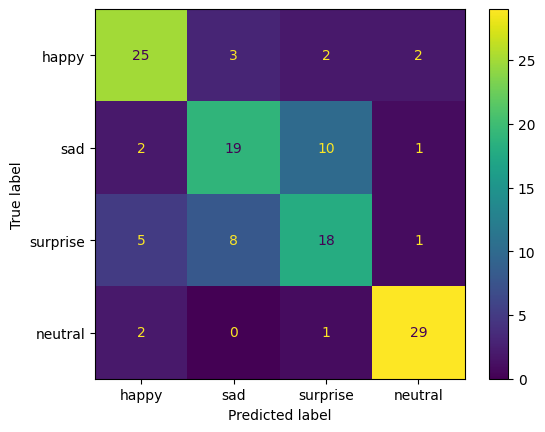

In [43]:
plot_confusion_matrix(cnn_model_2)

**Observations and Insights:**

*  The model is the surest about the neutral emotion closely followed by the happy emotion.
*  The model confuses surprise emotions with sad emotions just as the previous models.  I'm getting more convinced that it has something to do with the eyes.



## **Think About It:**

* Did the models have a satisfactory performance? If not, then what are the possible reasons?

  - The models performed well. The best performing model was the CNN 2 model which had more layers and used the grayscale color mode. Augemented the training data in-term giving the model more data to train on has prevented overfitting. Also early stopping has helped in getting the best version of the model before it began to overfit.  I will like to see the accuracy increase so maybe more layers will help with that.
* Which Color mode showed better overall performance? What are the possible reasons? Do you think having 'rgb' color mode is needed because the images are already black and white?

  - The **RGB** mode model performed slightly better.  This is probably due to the emotions depending on the shapes and not depending on the color of the images to be categorized.  Also maybe there are some very subtle color variations that can't been seen.

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.

## **VGG16 Model**

#### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

### **Importing the VGG16 Architecture**

In [44]:
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_input_vgg16

In [69]:
train_set = load_data(TRAINING_DATA_DIR, augment=True, shuffle=True, color_mode = 'rgb', add_noise=True, preprocessing_func=preprocess_input_vgg16);
test_set = load_data(TEST_DATA_DIR, color_mode = 'rgb');
validation_set = load_data(VALIDATION_DATA_DIR, color_mode = 'rgb', preprocessing_func=preprocess_input_vgg16);

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_set)

Found 15109 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.

In [51]:
reset()

In [52]:
# by setting include_top = False the model will be imported without the fully-connected layers
base_vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))
base_vgg_model.trainable = False  # freeze the layers in the base VGG16 model to prevent them from being updated during training
base_vgg_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [53]:
vgg_model = Sequential([
    base_vgg_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(CLASS_COUNT, activation='softmax')
])

# print a summary of the model architecture
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 14750196 (56.27 MB)
Trainable params: 3550

#### **Compiling and Training the VGG16 Model**

In [70]:
# Create an Adam optimizer with a learning rate of 0.001
optimizer = optimizers.Adam(learning_rate=0.001)

# Compile model
vgg_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

best_vgg_model = "best_vgg_model.h5"

# stop the training when a validation accuracy has stopped improving
es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=5, restore_best_weights=True)

# save the best model during training
mc = ModelCheckpoint(best_vgg_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model to the train dataset
vgg_model_history = vgg_model.fit(train_set,
                                  validation_data = validation_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.2730 - accuracy: 0.3937
Epoch 1: val_accuracy improved from -inf to 0.45730, saving model to best_vgg_model.h5
473/473 [==============================] - 32s 63ms/step - loss: 1.2730 - accuracy: 0.3937 - val_loss: 1.1881 - val_accuracy: 0.4573
Epoch 2/100
  1/473 [..............................] - ETA: 35s - loss: 1.0771 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - ETA: 0s - loss: 1.2221 - accuracy: 0.4351
Epoch 2: val_accuracy improved from 0.45730 to 0.49066, saving model to best_vgg_model.h5
473/473 [==============================] - 29s 61ms/step - loss: 1.2221 - accuracy: 0.4351 - val_loss: 1.1517 - val_accuracy: 0.4907
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.2023 - accuracy: 0.4583
Epoch 3: val_accuracy did not improve from 0.49066
473/473 [==============================] - 28s 59ms/step - loss: 1.2023 - accuracy: 0.4583 - val_loss: 1.1853 - val_accuracy: 0.4738
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.1930 - accuracy: 0.4586
Epoch 4: val_accuracy did not improve from 0.49066
473/473 [==============================] - 28s 59ms/step - loss: 1.1930 - accuracy: 0.4586 - val_loss: 1.1781 - val_accuracy: 0.4816
Epoch 5/100
473/473 [==============================] - ETA: 0s - loss: 1.1840 - accuracy: 0.4626
Epoch 5: val_accuracy improved fr

#### **Evaluating the VGG16 model**

In [71]:
# load the best model
vgg_model.load_weights(best_vgg_model)

Maximum Training Accuracy Score: 49.66%
Maximum Validation Accuracy Score: 54.17%


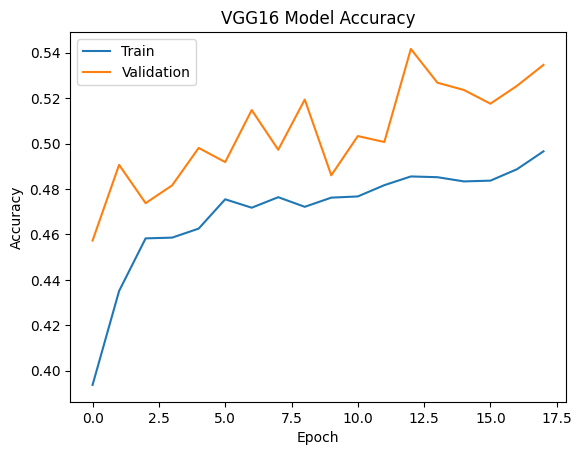

In [72]:
plot_history(vgg_model_history, "VGG16 Model")

In [73]:
# get the accuracy value
accuracy = vgg_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 1.0995 - accuracy: 0.4844 - 81ms/epoch - 20ms/step
Test Accuracy: 48.44%


**Observations and Insights:**

- The VGG model has an accuracy of 48% on the test data.  Decreasing from the CNN model's 71%.
- This model is not performing as well as the CNN models.

#### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

       happy       0.38      0.56      0.46        32
         sad       0.29      0.31      0.30        32
    surprise       0.62      0.41      0.49        32
     neutral       0.81      0.66      0.72        32

    accuracy                           0.48       128
   macro avg       0.53      0.48      0.49       128
weighted avg       0.53      0.48      0.49       128



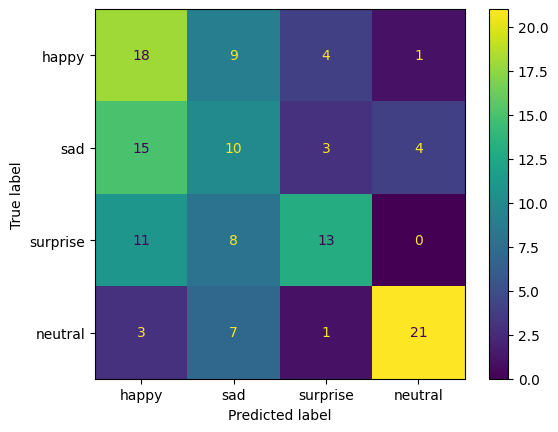

In [74]:
plot_confusion_matrix(vgg_model)

**Observations and Insights:**

* Like the previous models, the model is most sure about the neutral emotions.
* And like the model the model confuses sad emotions.
* The sad emotion has the lowest f1-score.

**Think About It:**

- What do you infer from the general trend in the training performance?
  - Although the VGG16 is good at picking out what images are, it may not be as good understanding emotions on faces.
  - Maybe a more fully connected layers will help.
  - Maybe changing the optimization and/or acivation functions will help.
  - Maybe chaning the learning rate will help.
  - Looks like the CNN model is outperforming all the other models on the validation data.  I would have predicted VGG would be the top performer, but it is not.  It will be interesting to see that happens with the next models.
- Is the training accuracy consistently improving?
  - No, the training data is dropped from 67% to 50%.
- Is the validation accuracy also improving similarly?
  - No the validation accuracy is not improving from the CNN model while it decreased from 72% to 54%.

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**

### **Model 2 Building**

- Adding LeakyRelu layers
- Changing the Optimization Function to SGD
- Using the default learning rate

In [75]:
reset()

In [76]:
# by setting include_top = False the model will be imported without the fully-connected layers
base_vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))
base_vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [77]:
vgg_model_2 = Sequential([
    base_vgg_model,
    GlobalAveragePooling2D(),
    LeakyReLU(alpha=0.1),
    Flatten(),
    Dense(1024, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    Dense(512, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(256, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(32, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(16, activation='relu'),
    Dense(CLASS_COUNT, activation='softmax')
])

# print a summary of the model architecture
vgg_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 1024)              0         
                                                        

#### **Compiling and Training the VGG16 Model**

In [78]:
# Create an Stochastic Gradient Descent optimizer with a default learning rate
optimizer = optimizers.SGD()

# Compile model
vgg_model_2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

best_vgg_2_model = "best_vgg_2_model.h5"

# stop the training when a validation accuracy has stopped improving
es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=5, restore_best_weights=True)

# save the best model during training
mc = ModelCheckpoint(best_vgg_2_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model to the train dataset
vgg_model_2_history = vgg_model_2.fit(train_set,
                                  validation_data = validation_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.2850 - accuracy: 0.3584
Epoch 1: val_accuracy improved from -inf to 0.44002, saving model to best_vgg_2_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - 34s 62ms/step - loss: 1.2850 - accuracy: 0.3584 - val_loss: 1.2637 - val_accuracy: 0.4400
Epoch 2/100
473/473 [==============================] - ETA: 0s - loss: 1.0829 - accuracy: 0.5212
Epoch 2: val_accuracy improved from 0.44002 to 0.64577, saving model to best_vgg_2_model.h5
473/473 [==============================] - 28s 60ms/step - loss: 1.0829 - accuracy: 0.5212 - val_loss: 0.8801 - val_accuracy: 0.6458
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 0.9197 - accuracy: 0.6212
Epoch 3: val_accuracy improved from 0.64577 to 0.70665, saving model to best_vgg_2_model.h5
473/473 [==============================] - 29s 60ms/step - loss: 0.9197 - accuracy: 0.6212 - val_loss: 0.7482 - val_accuracy: 0.7067
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 0.8167 - accuracy: 0.6666
Epoch 4: val_accuracy improved from 0.70665 to 0.71710, saving model to best_vgg_2_model.h5
473/473 [=========================

#### **Evaluating 2nd VGG16 model**

In [79]:
# load the best model
vgg_model_2.load_weights(best_vgg_2_model)

Maximum Training Accuracy Score: 78.77%
Maximum Validation Accuracy Score: 77.48%


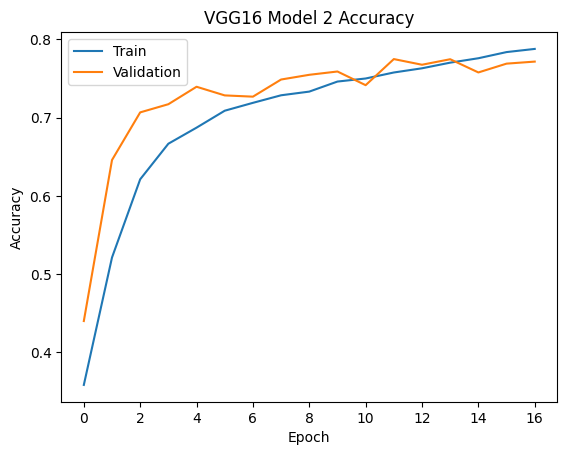

In [80]:
plot_history(vgg_model_2_history, "VGG16 Model 2")

In [81]:
# get the accuracy value
accuracy = vgg_model_2.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.5223 - accuracy: 0.7812 - 79ms/epoch - 20ms/step
Test Accuracy: 78.12%


**Observations and Insights:**

- The VGG model has an accuracy of 78% on the test data.  Increasing from the first VGG model's 48%.
- This model is outperforming all the other models as far accuracies on both the validation and test data.
- But this model is showing signs of overfitting the training data.
- The overfitting begins around epoch 13 which is after I saved the best epoch 12.


#### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

       happy       0.78      0.97      0.86        32
         sad       0.68      0.66      0.67        32
    surprise       0.74      0.62      0.68        32
     neutral       0.93      0.88      0.90        32

    accuracy                           0.78       128
   macro avg       0.78      0.78      0.78       128
weighted avg       0.78      0.78      0.78       128



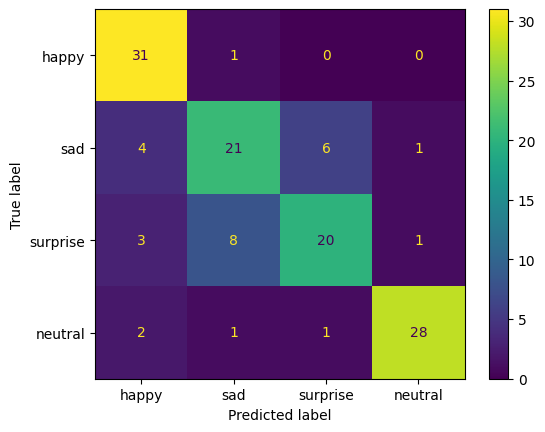

In [82]:
plot_confusion_matrix(vgg_model_2)

**Observations and Insights:**

* This model has the highest f1-scores so far.
* The model is most sure about neutral and happy emtions.
* The main confusion with this model is detecting surprise vs sad emotions.
* The sad emotion has the lowest f1-score but the score.

## **ResNet V2 Model**

### **Importing the ResNet V2 Architecture**

In [83]:
from keras.applications import ResNet50V2
from keras.applications.resnet50 import preprocess_input as resnet_preprocess_input

### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.

In [84]:
train_set = load_data(TRAINING_DATA_DIR, augment=True, shuffle=True, color_mode = 'rgb', add_noise=True, preprocessing_func=resnet_preprocess_input);
test_set = load_data(TEST_DATA_DIR, color_mode = 'rgb');
validation_set = load_data(VALIDATION_DATA_DIR, color_mode = 'rgb', preprocessing_func=resnet_preprocess_input);

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_set)

Found 15109 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.

In [85]:
reset()

In [86]:
# Load the ResNetV2 model without including the top fully connected layers
base_res_net_model = ResNet50V2(weights='imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))
base_res_net_model.trainable = False
base_res_net_model.summary()

94668760/94668760 [==============================] - 5s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 26, 26, 64)           0         ['conv1_conv[0][0]']          
                        

In [102]:
res_net_model = Sequential([
    base_res_net_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dense(64, activation='relu'),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),
    BatchNormalization(),
    Dense(CLASS_COUNT, activation='softmax')
])

# print a summary of the model architecture
res_net_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dense_28 (Dense)            (None, 256)               2097408   
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

### **Compiling and Training the Model**

In [103]:
# compile the adam optimizer
optimizer = Adam()

# Compile model
res_net_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

best_res_net_model = "best_res_net_model.h5"

# stop the training when a validation accuracy has stopped improving
es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=5, restore_best_weights=True)

# save the best model during training
mc = ModelCheckpoint(best_res_net_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model to the train dataset
res_net_model_history = res_net_model.fit(train_set,
                                  validation_data = validation_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.4315 - accuracy: 0.3521
Epoch 1: val_accuracy improved from -inf to 0.46333, saving model to best_res_net_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - 37s 66ms/step - loss: 1.4315 - accuracy: 0.3521 - val_loss: 1.2434 - val_accuracy: 0.4633
Epoch 2/100
473/473 [==============================] - ETA: 0s - loss: 1.2838 - accuracy: 0.4118
Epoch 2: val_accuracy improved from 0.46333 to 0.50291, saving model to best_res_net_model.h5
473/473 [==============================] - 30s 63ms/step - loss: 1.2838 - accuracy: 0.4118 - val_loss: 1.1462 - val_accuracy: 0.5029
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.2205 - accuracy: 0.4540
Epoch 3: val_accuracy improved from 0.50291 to 0.53205, saving model to best_res_net_model.h5
473/473 [==============================] - 30s 63ms/step - loss: 1.2205 - accuracy: 0.4540 - val_loss: 1.0978 - val_accuracy: 0.5320
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.1875 - accuracy: 0.4781
Epoch 4: val_accuracy improved from 0.53205 to 0.54631, saving model to best_res_net_model.h5
473/473 [===================

### **Evaluating the ResNet Model**

In [105]:
# load the best model
res_net_model.load_weights(best_res_net_model)

Maximum Training Accuracy Score: 55.33%
Maximum Validation Accuracy Score: 58.67%


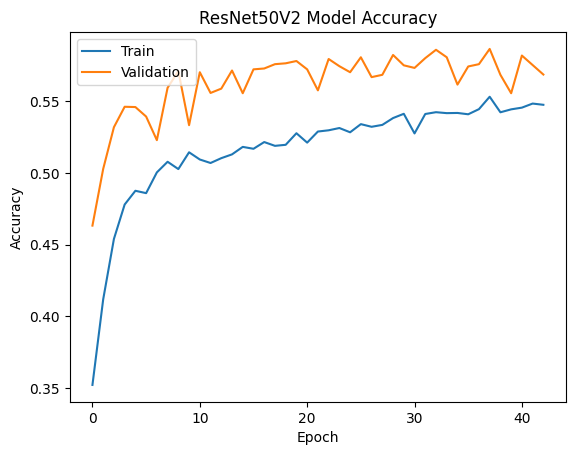

In [106]:
plot_history(res_net_model_history, "ResNet50V2 Model")

In [107]:
# get the accuracy value
accuracy = res_net_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 1.1033 - accuracy: 0.5391 - 97ms/epoch - 24ms/step
Test Accuracy: 53.91%


**Observations and Insights:**

- The ResNet model has an accuracy of 54% on the test data.  Decreasing from the first VGG model's 78%.
- The model is not performing as well as VGG model.



### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

       happy       0.47      0.84      0.60        32
         sad       0.44      0.38      0.41        32
    surprise       0.56      0.31      0.40        32
     neutral       0.80      0.62      0.70        32

    accuracy                           0.54       128
   macro avg       0.57      0.54      0.53       128
weighted avg       0.57      0.54      0.53       128



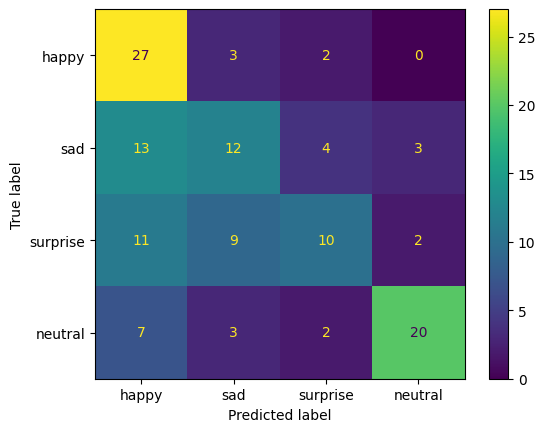

In [108]:
plot_confusion_matrix(res_net_model)

**Observations and Insights:**

- The ResNet model is surest about the neutral emotion.
- It is very unsure abou the sad emotion and often confuses it with happy emotion.


**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**

## **EfficientNet Model**

### **Importing the Efficient Model Architecture**

In [168]:
from keras.applications import EfficientNetB3
from keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input

### **Creating our Data Loaders for Transfer Learning Architectures**

In [169]:
train_set = load_data(TRAINING_DATA_DIR, augment=True, shuffle=True, color_mode = 'rgb', add_noise=True);
test_set = load_data(TEST_DATA_DIR, color_mode = 'rgb');
validation_set = load_data(VALIDATION_DATA_DIR, color_mode = 'rgb');

# get all the test data for prediction purposes
testX, testY = get_test_data_split(test_set)

Found 15109 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.

In [152]:
reset()

In [170]:
# Load the EfficientNet model without including the top fully connected layers
base_efficient_net_model = EfficientNetB3(include_top=False, weights='imagenet', pooling='max', input_shape=(IMG_SIZE,IMG_SIZE,3))
#base_efficient_net_model.trainable = False
base_efficient_net_model.summary()

Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 48, 48, 3)            0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 48, 48, 3)            7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 48, 48, 3)            0         ['normalization_2

In [171]:
efficient_net_model = Sequential([
    base_efficient_net_model,
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(CLASS_COUNT, activation='softmax')
])

# print a summary of the model architecture
efficient_net_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_8 (Dense)             (None, 256)               393472    
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 11218419 (42.79 MB)
Trainable params: 11131116 (42.46 MB)
Non-trainable params: 87303 (341.03 KB)
________

### **Compiling and Training the Model**

In [172]:
# compile the adam optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile model
efficient_net_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

best_efficient_net_model = "best_efficient_net_model.h5"

# stop the training when a validation accuracy has stopped improving
es = EarlyStopping(monitor="val_accuracy", mode='max', verbose=1, patience=5, restore_best_weights=True)

# save the best model during training
mc = ModelCheckpoint(best_efficient_net_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model to the train dataset
efficient_net_model_history = efficient_net_model.fit(train_set,
                                  validation_data = validation_set,
                                  verbose = 1,
                                  epochs = 100,
                                  callbacks=[es, mc])

Epoch 1/100
473/473 [==============================] - ETA: 0s - loss: 1.3629 - accuracy: 0.3304
Epoch 1: val_accuracy improved from -inf to 0.24171, saving model to best_efficient_net_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


473/473 [==============================] - 95s 86ms/step - loss: 1.3629 - accuracy: 0.3304 - val_loss: 1.4413 - val_accuracy: 0.2417
Epoch 2/100
473/473 [==============================] - ETA: 0s - loss: 1.2567 - accuracy: 0.4192
Epoch 2: val_accuracy improved from 0.24171 to 0.33936, saving model to best_efficient_net_model.h5
473/473 [==============================] - 37s 79ms/step - loss: 1.2567 - accuracy: 0.4192 - val_loss: 1.3779 - val_accuracy: 0.3394
Epoch 3/100
473/473 [==============================] - ETA: 0s - loss: 1.1751 - accuracy: 0.4742
Epoch 3: val_accuracy improved from 0.33936 to 0.49226, saving model to best_efficient_net_model.h5
473/473 [==============================] - 37s 79ms/step - loss: 1.1751 - accuracy: 0.4742 - val_loss: 1.1476 - val_accuracy: 0.4923
Epoch 4/100
473/473 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.5227
Epoch 4: val_accuracy did not improve from 0.49226
473/473 [==============================] - 36s 77ms/step - 

### **Evaluating the EfficientnetNet Model**

In [173]:
# load the best model
efficient_net_model.load_weights(best_efficient_net_model)

Maximum Training Accuracy Score: 72.10%
Maximum Validation Accuracy Score: 69.80%


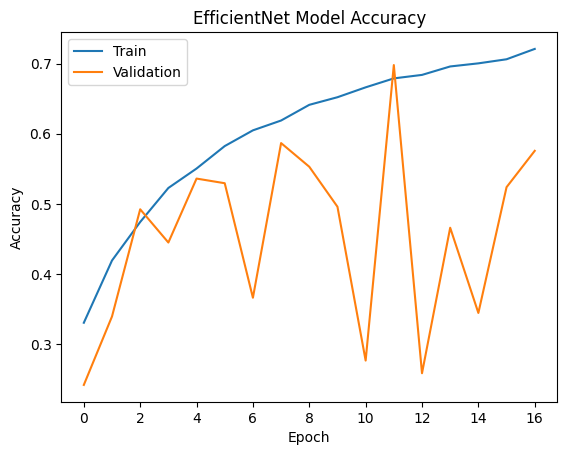

In [174]:
plot_history(efficient_net_model_history, "EfficientNet Model")

In [175]:
# get the accuracy value
accuracy = efficient_net_model.evaluate(testX, testY, verbose = 2)

print(f'Test Accuracy: {accuracy[1]*100:.2f}%')

4/4 - 0s - loss: 0.7105 - accuracy: 0.6953 - 119ms/epoch - 30ms/step
Test Accuracy: 69.53%


**Observations and Insights:**

- The EfficientNet model has an accuracy of 70% on the test data.  Decreasing from the first VGG model's 78% but performing better than the ResNet model.
- The top performaing epoch was epoch 12 with a 72% accuracy on the validation data.
- The accuracy didn't start to rise until I removed the Flatten layer.
- The model is not performing as well.

### **Classification Report and Confusion Matrix for Test Predictions**

4/4 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

       happy       0.72      0.81      0.76        32
         sad       0.53      0.56      0.55        32
    surprise       0.64      0.56      0.60        32
     neutral       0.90      0.84      0.87        32

    accuracy                           0.70       128
   macro avg       0.70      0.70      0.70       128
weighted avg       0.70      0.70      0.70       128



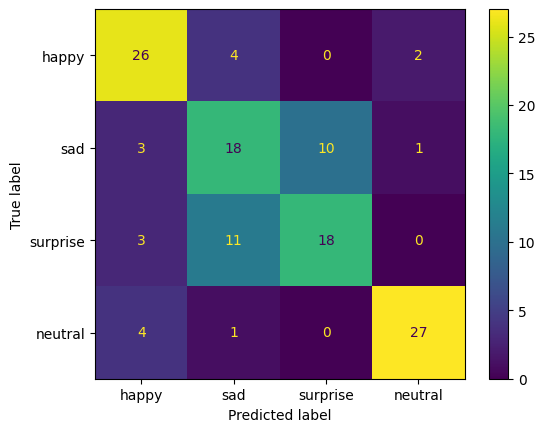

In [176]:
plot_confusion_matrix(efficient_net_model)

**Observations and Insights:**

- Like all the previous models, EfficientNet model is surest about the neutral emotion.
- The model is also the most unsure about the sad emotion, it confuses it with the surprise emotion mostly.  I have come to a theory this model and the previous ones must be using the eyes as the main features but that's just a theory.


**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**

**Think About It:**

* What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
* Do you think our issue lies with 'rgb' color_mode?

Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.

## **Building a Complex Neural Network Architecture**

In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.

## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.

### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.

### **Compiling and Training the Model**

### **Evaluating the Model on Test Set**

**Observations and Insights:__**

### **Plotting the Confusion Matrix for the chosen final model**

**Observations and Insights:__**

## **Conclusion:____________**

### **Insights**

### **Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

### **Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

### **Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?